In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
try:
    from xgboost import XGBClassifier
except ImportError:
    print("XGBoost not installed. To install: !pip install xgboost")
import joblib
import os

# Set visualization options
%matplotlib inline
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Define the AdvancedMLPipeline class
class AdvancedMLPipeline:
    def __init__(self, model_type='rf', n_components=10, remove_outliers=True):
        # Initialize all components: model, imputers, encoder, PCA
        model_map = {
            'gb': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
            'rf': RandomForestClassifier(n_estimators=100, random_state=42),
            'xgb': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        }
        self.model = model_map[model_type]
        self.scaler = StandardScaler()
        self.imputer_num = SimpleImputer(strategy='mean')
        self.imputer_cat = SimpleImputer(strategy='most_frequent')
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.pca = PCA(n_components=n_components)
        self.remove_outliers = remove_outliers
        self.cat_columns = []
        self.feature_columns = []

    def _add_features(self, df):
        # Create time features from TransactionDT
        if 'TransactionDT' in df.columns:
            df['hour'] = pd.to_datetime(df['TransactionDT'], unit='s', errors='coerce').dt.hour.astype('Int8')
            df['day'] = pd.to_datetime(df['TransactionDT'], unit='s', errors='coerce').dt.dayofweek.astype('Int8')
            df.drop(columns=['TransactionDT'], inplace=True)

        # Group-level aggregation features
        c_cols = [col for col in df.columns if col.startswith('C')]
        d_cols = [col for col in df.columns if col.startswith('D')]
        v_cols = [col for col in df.columns if col.startswith('V')]

        df['C_sum'] = df[c_cols].sum(axis=1)
        df['D_missing'] = df[d_cols].isnull().sum(axis=1)
        df['V_mean'] = df[v_cols].mean(axis=1)
        return df

    def _remove_outliers(self, df, col='TransactionAmt'):
        # Remove outliers from TransactionAmt using IQR
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            before = df.shape[0]
            df = df[(df[col] >= lower) & (df[col] <= upper)]
            after = df.shape[0]
            print(f"Removed {before - after} outliers from {col}")
        return df

    def fit_model_on_chunk(self, df, label_column='isFraud'):
        df = self._add_features(df)

        if self.remove_outliers:
            df = self._remove_outliers(df)

        # Convert known categoricals to string
        known_cats = ['ProductCD', 'card4', 'card6', 'DeviceType', 'DeviceInfo',
                      'M1','M2','M3','M4','M5','M6','M7','M8','M9']
        for col in known_cats:
            if col in df.columns:
                df[col] = df[col].astype(str)

        # Identify categorical and numeric columns
        self.cat_columns = [col for col in df.columns if df[col].dtype == 'object' and col != label_column]
        num_cols = [col for col in df.columns if col not in self.cat_columns + [label_column, 'TransactionID']]

        # Impute missing values
        if self.cat_columns:
            df[self.cat_columns] = self.imputer_cat.fit_transform(df[self.cat_columns])
        if num_cols:
            df[num_cols] = self.imputer_num.fit_transform(df[num_cols])

        # One-hot encode categorical features
        encoded = self.encoder.fit_transform(df[self.cat_columns])
        encoded_df = pd.DataFrame(encoded, columns=self.encoder.get_feature_names_out(self.cat_columns), index=df.index)

        # Replace original categoricals with encoded version
        df = df.drop(columns=self.cat_columns)
        df = pd.concat([df, encoded_df], axis=1)

        # Scale numeric columns
        if num_cols:
            df[num_cols] = self.scaler.fit_transform(df[num_cols])

        # Apply PCA on V-columns
        v_cols = [col for col in df.columns if col.startswith('V')]
        if v_cols:
            pca_trans = self.pca.fit_transform(df[v_cols])
            pca_df = pd.DataFrame(pca_trans, columns=[f'V_PCA_{i}' for i in range(pca_trans.shape[1])], index=df.index)
            df = df.drop(columns=v_cols)
            df = pd.concat([df, pca_df], axis=1)

        # Save the final feature columns
        self.feature_columns = [col for col in df.columns if col not in [label_column, 'TransactionID']]

        # Train model
        X = df[self.feature_columns]
        y = df[label_column]
        self.model.fit(X, y)

    def transform_for_predict(self, df):
        df = self._add_features(df)

        # Fill missing categorical values
        for col in self.cat_columns:
            if col not in df.columns:
                df[col] = "missing"
        df[self.cat_columns] = self.imputer_cat.transform(df[self.cat_columns])

        # Impute numeric
        num_cols = [col for col in df.columns if col not in self.cat_columns + ['TransactionID']]
        df[num_cols] = self.imputer_num.transform(df[num_cols])

        # Encode categoricals
        encoded = self.encoder.transform(df[self.cat_columns])
        encoded_df = pd.DataFrame(encoded, columns=self.encoder.get_feature_names_out(self.cat_columns), index=df.index)

        df = df.drop(columns=self.cat_columns)
        df = pd.concat([df, encoded_df], axis=1)

        # Scale numeric
        if num_cols:
            df[num_cols] = self.scaler.transform(df[num_cols])

        # Apply PCA to V columns
        v_cols = [col for col in df.columns if col.startswith('V')]
        if v_cols:
            pca_trans = self.pca.transform(df[v_cols])
            pca_df = pd.DataFrame(pca_trans, columns=[f'V_PCA_{i}' for i in range(pca_trans.shape[1])], index=df.index)
            df = df.drop(columns=v_cols)
            df = pd.concat([df, pca_df], axis=1)

        # Align columns with training
        for col in self.feature_columns:
            if col not in df.columns:
                df[col] = 0
        df = df[self.feature_columns]
        return df

    def evaluate(self, X, y_true):
        y_pred = self.model.predict(X)
        y_proba = self.model.predict_proba(X)[:, 1]
        print(classification_report(y_true, y_pred))
        print("ROC AUC:", roc_auc_score(y_true, y_proba))
        print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    def plot_roc_curve(self, X, y_true):
        from sklearn.metrics import roc_curve, auc
        y_proba = self.model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    def get_metrics(self, X, y_true):
        from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
        y_pred = self.model.predict(X)
        y_proba = self.model.predict_proba(X)[:, 1]
        return {
            'f1_score': f1_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'roc_auc': roc_auc_score(y_true, y_proba)
        }

print("AdvancedMLPipeline class defined successfully.")

AdvancedMLPipeline class defined successfully.


In [30]:
# Function to get a sample of data
def get_sample_data(file_path, sample_size=10000, random_state=42):
    """
    Get a random sample from a large dataset
    """
    # Read only first N rows to get column names
    df_temp = pd.read_csv(file_path, nrows=1)
    
    # Get total number of rows
    with open(file_path, 'r') as f:
        num_lines = sum(1 for _ in f) - 1  # Subtract header
    
    # Generate random row indices
    skip_indices = set(np.random.RandomState(random_state).choice(
        range(1, num_lines + 1), 
        size=num_lines - sample_size, 
        replace=False
    ))
    
    # Read data, skipping rows
    df = pd.read_csv(
        file_path,
        skiprows=lambda i: i > 0 and i in skip_indices
    )
    
    print(f"Loaded {df.shape[0]} samples with {df.shape[1]} features.")
    return df

# Create directories for model output
os.makedirs('model', exist_ok=True)

In [5]:
import os

# Check file existence
file_path = '/model-ec2/train_transaction.csv'
if os.path.exists(file_path):
    print(f"File found at {file_path}")
    # Check file size
    file_size = os.path.getsize(file_path) / (1024 * 1024)  # Convert to MB
    print(f"File size: {file_size:.2f} MB")
    
    # Preview first few rows
    import pandas as pd
    print("\nPreviewing first 5 rows:")
    df_sample = pd.read_csv(file_path, nrows=5)
    print(df_sample.head())
else:
    print(f"File not found at {file_path}. Please check the path.")
    
    # Try to locate the file
    import subprocess
    print("\nSearching for train_transaction.csv in common locations...")
    result = subprocess.run(['find', '/home', '-name', 'train_transaction.csv'], 
                           capture_output=True, text=True)
    if result.stdout:
        print(f"File found at: {result.stdout}")
    else:
        print("File not found in /home. Checking current directory...")
        result = subprocess.run(['find', '.', '-name', 'train_transaction.csv'], 
                               capture_output=True, text=True)
        if result.stdout:
            print(f"File found at: {result.stdout}")
        else:
            print("File not found in current directory.")

File not found at /model-ec2/train_transaction.csv. Please check the path.

Searching for train_transaction.csv in common locations...
File not found in /home. Checking current directory...
File not found in current directory.


In [32]:
# Check current working directory
import os
print(f"Current working directory: {os.getcwd()}")

# List files in current directory
import subprocess
result = subprocess.run(['ls', '-la'], capture_output=True, text=True)
print("\nFiles in current directory:")
print(result.stdout)

# Try to find the file with a more comprehensive search
print("\nSearching for train_transaction.csv file...")
result = subprocess.run(['find', os.getcwd(), '-name', 'train_transaction.csv', '-type', 'f'], 
                       capture_output=True, text=True)
if result.stdout:
    print(f"File found at: {result.stdout.strip()}")
    file_path = result.stdout.strip()
else:
    print("File not found in current directory tree.")
    
    # Look in home directory
    home_dir = os.path.expanduser("~")
    print(f"\nSearching in home directory ({home_dir})...")
    result = subprocess.run(['find', home_dir, '-name', 'train_transaction.csv', '-type', 'f'], 
                           capture_output=True, text=True)
    if result.stdout:
        print(f"File found at: {result.stdout.strip()}")
        file_path = result.stdout.strip()
    else:
        print("File not found in home directory.")

Current working directory: /workspace/notebooks

Files in current directory:
total 667460
drwxrwxr-x 5 1000 1000      4096 May 18 20:20 .
drwxr-xr-x 1 root root      4096 May 18 05:54 ..
drwxr-xr-x 2 root root      4096 May 18 06:02 .ipynb_checkpoints
drwxrwxr-x 2 1000 1000      4096 May 18 06:34 __pycache__
-rw-rw-r-- 1 1000 1000      4560 May 18 06:34 app.py
-rw-r--r-- 1 root root     92697 May 18 20:20 fraud_detection_model.ipynb
drwxr-xr-x 2 root root      4096 May 18 06:30 model
-rw-rw-r-- 1 1000 1000 683351067 May  2 17:59 train_transaction.csv


Searching for train_transaction.csv file...
File found at: /workspace/notebooks/train_transaction.csv


Loaded 10000 samples with 394 features.
Training model on sample data...
Removed 849 outliers from TransactionAmt


/tmp/ipykernel_27/157073207.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str)
/tmp/ipykernel_27/157073207.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str)
/tmp/ipykernel_27/157073207.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm


Evaluating model on validation data...
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1929
           1       1.00      0.18      0.31        71

    accuracy                           0.97      2000
   macro avg       0.99      0.59      0.65      2000
weighted avg       0.97      0.97      0.96      2000

ROC AUC: 0.821866397973116
Confusion Matrix:
 [[1929    0]
 [  58   13]]


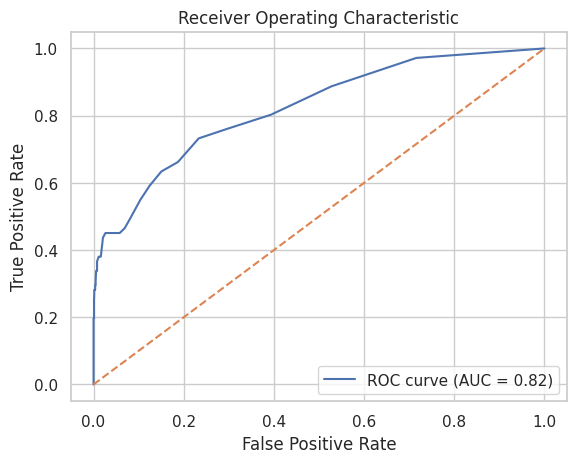


Model and pipeline saved to /workspace/notebooks/model/ directory


In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
try:
    from xgboost import XGBClassifier
except ImportError:
    print("XGBoost not installed. To install: !pip install xgboost")
import joblib
import os

# Set visualization options
%matplotlib inline
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Define the AdvancedMLPipeline class
class AdvancedMLPipeline:
    def __init__(self, model_type='rf', n_components=10, remove_outliers=True):
        # Initialize all components: model, imputers, encoder, PCA
        model_map = {
            'gb': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
            'rf': RandomForestClassifier(n_estimators=100, random_state=42),
            'xgb': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        }
        self.model = model_map[model_type]
        self.scaler = StandardScaler()
        self.imputer_num = SimpleImputer(strategy='mean')
        self.imputer_cat = SimpleImputer(strategy='most_frequent')
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.pca = PCA(n_components=n_components)
        self.remove_outliers = remove_outliers
        self.cat_columns = []
        self.feature_columns = []

    def _add_features(self, df):
        # Create time features from TransactionDT
        if 'TransactionDT' in df.columns:
            df['hour'] = pd.to_datetime(df['TransactionDT'], unit='s', errors='coerce').dt.hour.astype('Int8')
            df['day'] = pd.to_datetime(df['TransactionDT'], unit='s', errors='coerce').dt.dayofweek.astype('Int8')
            df.drop(columns=['TransactionDT'], inplace=True)

        # Group-level aggregation features
        c_cols = [col for col in df.columns if col.startswith('C')]
        d_cols = [col for col in df.columns if col.startswith('D')]
        v_cols = [col for col in df.columns if col.startswith('V')]

        df['C_sum'] = df[c_cols].sum(axis=1)
        df['D_missing'] = df[d_cols].isnull().sum(axis=1)
        df['V_mean'] = df[v_cols].mean(axis=1)
        return df

    def _remove_outliers(self, df, col='TransactionAmt'):
        # Remove outliers from TransactionAmt using IQR
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            before = df.shape[0]
            df = df[(df[col] >= lower) & (df[col] <= upper)]
            after = df.shape[0]
            print(f"Removed {before - after} outliers from {col}")
        return df

    def fit_model_on_chunk(self, df, label_column='isFraud'):
        df = self._add_features(df)

        if self.remove_outliers:
            df = self._remove_outliers(df)

        # Convert known categoricals to string
        known_cats = ['ProductCD', 'card4', 'card6', 'DeviceType', 'DeviceInfo',
                      'M1','M2','M3','M4','M5','M6','M7','M8','M9']
        for col in known_cats:
            if col in df.columns:
                df[col] = df[col].astype(str)

        # Identify categorical and numeric columns
        self.cat_columns = [col for col in df.columns if df[col].dtype == 'object' and col != label_column]
        num_cols = [col for col in df.columns if col not in self.cat_columns + [label_column, 'TransactionID']]

        # Impute missing values
        if self.cat_columns:
            df[self.cat_columns] = self.imputer_cat.fit_transform(df[self.cat_columns])
        if num_cols:
            df[num_cols] = self.imputer_num.fit_transform(df[num_cols])

        # One-hot encode categorical features
        encoded = self.encoder.fit_transform(df[self.cat_columns])
        encoded_df = pd.DataFrame(encoded, columns=self.encoder.get_feature_names_out(self.cat_columns), index=df.index)

        # Replace original categoricals with encoded version
        df = df.drop(columns=self.cat_columns)
        df = pd.concat([df, encoded_df], axis=1)

        # Scale numeric columns
        if num_cols:
            df[num_cols] = self.scaler.fit_transform(df[num_cols])

        # Apply PCA on V-columns
        v_cols = [col for col in df.columns if col.startswith('V')]
        if v_cols:
            pca_trans = self.pca.fit_transform(df[v_cols])
            pca_df = pd.DataFrame(pca_trans, columns=[f'V_PCA_{i}' for i in range(pca_trans.shape[1])], index=df.index)
            df = df.drop(columns=v_cols)
            df = pd.concat([df, pca_df], axis=1)

        # Save the final feature columns
        self.feature_columns = [col for col in df.columns if col not in [label_column, 'TransactionID']]

        # Train model
        X = df[self.feature_columns]
        y = df[label_column]
        self.model.fit(X, y)

    def transform_for_predict(self, df):
        df = self._add_features(df)

        # Fill missing categorical values
        for col in self.cat_columns:
            if col not in df.columns:
                df[col] = "missing"
        df[self.cat_columns] = self.imputer_cat.transform(df[self.cat_columns])

        # Impute numeric
        num_cols = [col for col in df.columns if col not in self.cat_columns + ['TransactionID']]
        df[num_cols] = self.imputer_num.transform(df[num_cols])

        # Encode categoricals
        encoded = self.encoder.transform(df[self.cat_columns])
        encoded_df = pd.DataFrame(encoded, columns=self.encoder.get_feature_names_out(self.cat_columns), index=df.index)

        df = df.drop(columns=self.cat_columns)
        df = pd.concat([df, encoded_df], axis=1)

        # Scale numeric
        if num_cols:
            df[num_cols] = self.scaler.transform(df[num_cols])

        # Apply PCA to V columns
        v_cols = [col for col in df.columns if col.startswith('V')]
        if v_cols:
            pca_trans = self.pca.transform(df[v_cols])
            pca_df = pd.DataFrame(pca_trans, columns=[f'V_PCA_{i}' for i in range(pca_trans.shape[1])], index=df.index)
            df = df.drop(columns=v_cols)
            df = pd.concat([df, pca_df], axis=1)

        # Align columns with training
        for col in self.feature_columns:
            if col not in df.columns:
                df[col] = 0
        df = df[self.feature_columns]
        return df

    def evaluate(self, X, y_true):
        y_pred = self.model.predict(X)
        y_proba = self.model.predict_proba(X)[:, 1]
        print(classification_report(y_true, y_pred))
        print("ROC AUC:", roc_auc_score(y_true, y_proba))
        print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    def plot_roc_curve(self, X, y_true):
        from sklearn.metrics import roc_curve, auc
        y_proba = self.model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    def get_metrics(self, X, y_true):
        from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
        y_pred = self.model.predict(X)
        y_proba = self.model.predict_proba(X)[:, 1]
        return {
            'f1_score': f1_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'roc_auc': roc_auc_score(y_true, y_proba)
        }

# Function to get a sample of data
def get_sample_data(file_path, sample_size=10000, random_state=42):
    """
    Get a random sample from a large dataset
    """
    # Read only first N rows to get column names
    df_temp = pd.read_csv(file_path, nrows=1)
    
    # Get total number of rows
    with open(file_path, 'r') as f:
        num_lines = sum(1 for _ in f) - 1  # Subtract header
    
    # Generate random row indices
    skip_indices = set(np.random.RandomState(random_state).choice(
        range(1, num_lines + 1), 
        size=num_lines - sample_size, 
        replace=False
    ))
    
    # Read data, skipping rows
    df = pd.read_csv(
        file_path,
        skiprows=lambda i: i > 0 and i in skip_indices
    )
    
    print(f"Loaded {df.shape[0]} samples with {df.shape[1]} features.")
    return df

# Create directories for model output
os.makedirs('/home/ubuntu/model-ec2/notebooks/model', exist_ok=True)

# Use the correct path to the data file
data_file = '/home/ubuntu/model-ec2/notebooks/train_transaction.csv'

if not os.path.exists(data_file):
    print(f"ERROR: Data file '{data_file}' not found!")
    print("Please check the file path.")
else:
    # Get a sample of data (use a smaller sample_size if memory is limited)
    # Start with a small sample size to avoid memory issues
    train_df = get_sample_data(data_file, sample_size=10000)
    
    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        train_df.drop('isFraud', axis=1),
        train_df['isFraud'],
        test_size=0.2,
        random_state=42,
        stratify=train_df['isFraud']
    )
    
    # Train model
    print("Training model on sample data...")
    pipeline = AdvancedMLPipeline(model_type='rf', n_components=10, remove_outliers=True)
    pipeline.fit_model_on_chunk(X_train.assign(isFraud=y_train), label_column='isFraud')
    
    # Evaluate model
    print("\nEvaluating model on validation data...")
    X_val_transformed = pipeline.transform_for_predict(X_val)
    pipeline.evaluate(X_val_transformed, y_val)
    
    # Plot ROC curve
    pipeline.plot_roc_curve(X_val_transformed, y_val)
    
    # Save the model
    model_dir = '/home/ubuntu/model-ec2/notebooks/model'
    joblib.dump(pipeline.model, f'{model_dir}/model.pkl')
    joblib.dump(pipeline, f'{model_dir}/pipeline.pkl')
    
    print(f"\nModel and pipeline saved to {model_dir}/ directory")

In [34]:
# Create a reusable prediction module
prediction_module = '''
import pandas as pd
import joblib

class FraudDetectionPipeline:
    def __init__(self, model_path='/home/ubuntu/model-ec2/model/model.pkl', pipeline_path='/home/ubuntu/model-ec2/model/pipeline.pkl'):
        self.model = joblib.load(model_path)
        self.pipeline = joblib.load(pipeline_path)
    
    def predict(self, data):
        """
        Make fraud predictions on new data
        
        Args:
            data: DataFrame or dict with transaction data
            
        Returns:
            tuple: (prediction, probability)
        """
        # Convert dict to DataFrame if needed
        if isinstance(data, dict):
            data = pd.DataFrame([data])
            
        # Prepare data for model
        X = self.pipeline.transform_for_predict(data)
        
        # Make prediction
        prediction = self.model.predict(X)[0]
        probability = self.model.predict_proba(X)[0, 1]
        
        return prediction, probability
'''

with open('/home/ubuntu/model-ec2/notebooks/model/pipeline_module.py', 'w') as f:
    f.write(prediction_module)

print("Prediction module created at /home/ubuntu/model-ec2/notebooks/model/pipeline_module.py")

Prediction module created at /workspace/notebooks/model/pipeline_module.py


In [20]:
# Create a FastAPI app
fastapi_app = '''
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from typing import Dict, Any
import pandas as pd
import uvicorn
from model.pipeline_module import FraudDetectionPipeline

app = FastAPI(title="Fraud Detection API")
pipeline = FraudDetectionPipeline()

class TransactionRequest(BaseModel):
    data: Dict[str, Any]

class TransactionResponse(BaseModel):
    prediction: int
    probability: float
    is_fraud: bool

@app.post("/predict", response_model=TransactionResponse)
async def predict(request: TransactionRequest):
    try:
        prediction, probability = pipeline.predict(request.data)
        return {
            "prediction": int(prediction),
            "probability": float(probability),
            "is_fraud": bool(prediction == 1)
        }
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

@app.get("/")
async def root():
    return {"message": "Fraud Detection API is running. Use /predict endpoint."}

if __name__ == "__main__":
    uvicorn.run("app:app", host="0.0.0.0", port=8001)
'''

with open('/home/ubuntu/model-ec2/app.py', 'w') as f:
    f.write(fastapi_app)

print("FastAPI application created at /home/ubuntu/model-ec2/app.py")

FastAPI application created at /home/ubuntu/model-ec2/app.py
